# Hyperparameter tuning using the Optuna library

Loading data

In [1]:
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,precision_recall_curve, auc, precision_score, recall_score
import xgboost as xgb
import plotly
import pandas as pd
from sklearn.model_selection import cross_val_score

trainingdf=pd.read_csv("trainingdata.csv")
signalmask=trainingdf['y']==1
signaldf=trainingdf[signalmask]
backgrounddf=trainingdf[~signalmask]

def selectorderly(signal, background,trainingpercent, trainingsample,testingpercent, testingsample):
    signal=signal.sample(frac=1, random_state=42).reset_index(drop=True)
    background=background.sample(frac=1, random_state=42).reset_index(drop=True)
    trainingdata =pd.concat([signal.iloc[0:int(trainingpercent*trainingsample)],background.iloc[0:int((1-trainingpercent)*trainingsample)]],ignore_index=True)
    testingdata= pd.concat([signal.iloc[int(trainingpercent*trainingsample):int(testingpercent*testingsample+trainingpercent*trainingsample)],background.iloc[int((1-trainingpercent)*trainingsample):int((1-testingpercent)*testingsample+(1-trainingpercent)*trainingsample)]],ignore_index=True)
    return trainingdata,testingdata

Creating the Optuna objective function, in this case the area under curve (AUC) is to be maximized

In [2]:
def objective(trial):
    trainingdata, _= selectorderly(signaldf,backgrounddf,0.5,100000,0.14,200000)
    data=trainingdata.drop('y',axis=1)
    target=trainingdata['y']
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=(0.2),random_state=42)
    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "tree_method": "hist",  # or "gpu_hist" if GPU
        
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    model = xgb.XGBClassifier(**param,random_state=42, callbacks=[pruning_callback],early_stopping_rounds=50)
    model.fit(
        train_x, train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=False,
        
    )

    preds = model.predict_proba(valid_x)[:, 1]
    auc = roc_auc_score(valid_y, preds)
    return auc

Creating the Optuna studying and optimizing the XGBoost model

In [3]:
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),sampler=sampler,direction="maximize",study_name="xgb_2_study",
    storage="sqlite:///xgb_study.db", load_if_exists=True)

study.optimize(objective, n_trials=100, timeout=3600)

print("Best parameters:", study.best_trial.params)
print("Best score:", study.best_trial.value)

[I 2025-09-12 19:12:37,443] A new study created in RDB with name: xgb_2_study
[I 2025-09-12 19:13:24,903] Trial 0 finished with value: 0.9408441453407804 and parameters: {'learning_rate': 0.008468008575248327, 'n_estimators': 956}. Best is trial 0 with value: 0.9408441453407804.
[I 2025-09-12 19:13:49,965] Trial 1 finished with value: 0.9488720236822901 and parameters: {'learning_rate': 0.06504856968981275, 'n_estimators': 639}. Best is trial 1 with value: 0.9488720236822901.
[I 2025-09-12 19:13:50,520] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2025-09-12 19:13:51,129] Trial 3 pruned. Trial was pruned at iteration 1.
[I 2025-09-12 19:13:51,827] Trial 4 pruned. Trial was pruned at iteration 1.
[I 2025-09-12 19:14:41,209] Trial 5 finished with value: 0.9134920302773709 and parameters: {'learning_rate': 0.001124579825911934, 'n_estimators': 973}. Best is trial 1 with value: 0.9488720236822901.
[I 2025-09-12 19:14:57,502] Trial 6 finished with value: 0.9487828225895767 and parame

Best parameters: {'learning_rate': 0.15199494041354802, 'n_estimators': 613}
Best score: 0.9489217942919802


Visualization of the optimiztion and the trials

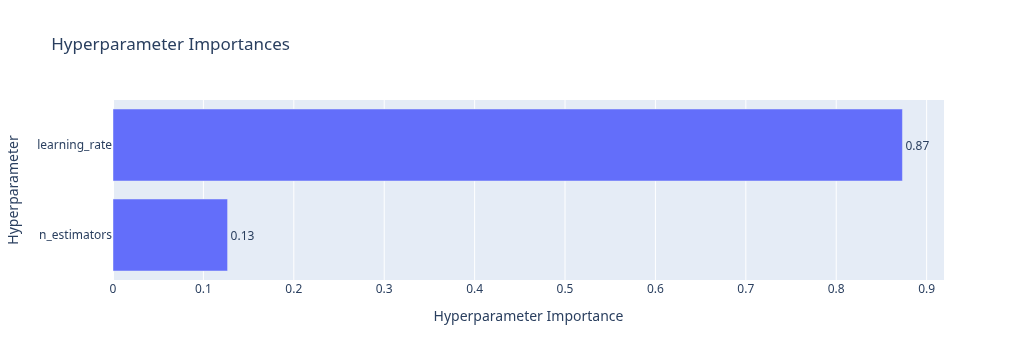

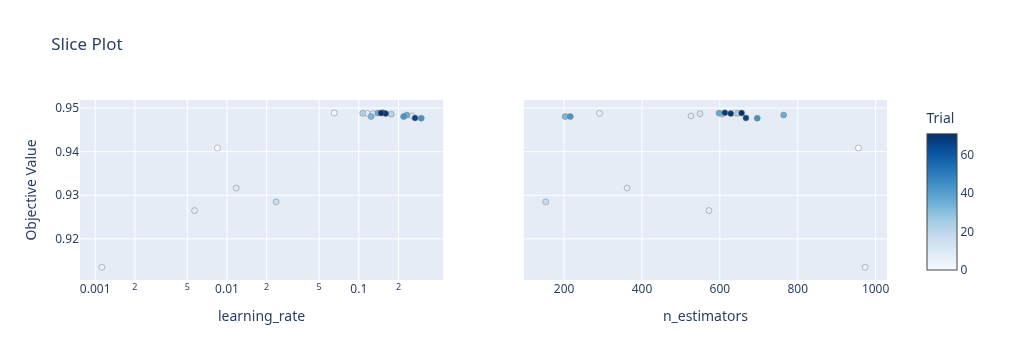

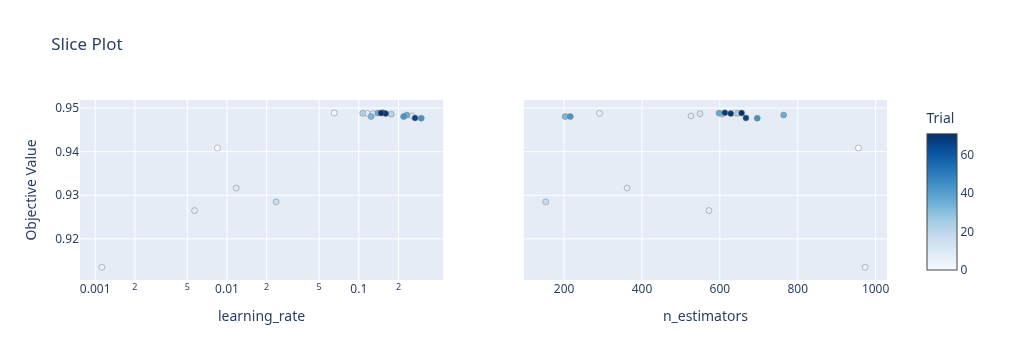

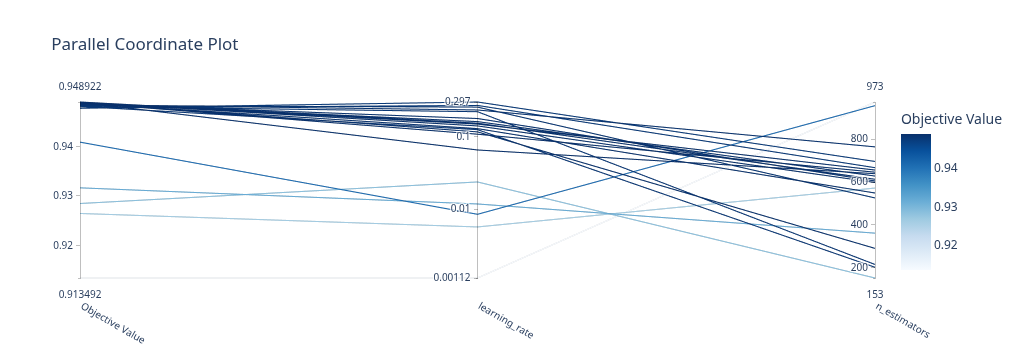

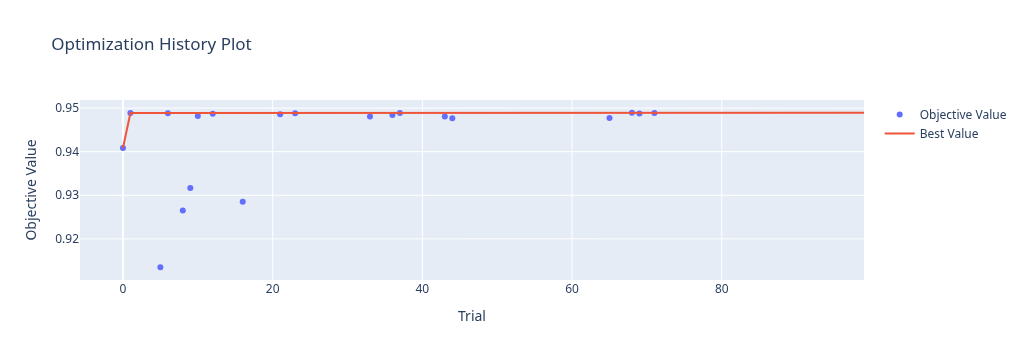

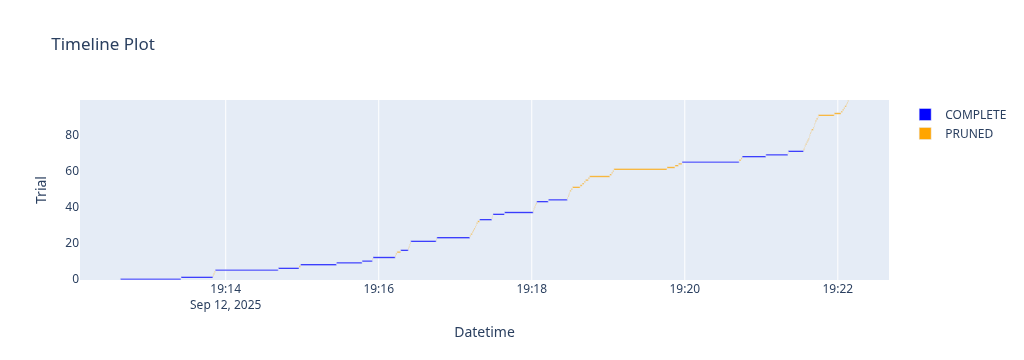

In [4]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
# Visualize parameter importances.
plot_param_importances(study).show()
plot_slice(study).show()
plot_slice(study, params=["n_estimators", "learning_rate"]).show()
plot_parallel_coordinate(study).show()
plot_optimization_history(study).show()
optuna.visualization.plot_timeline(study).show()



Applying optimized model to the test data to see performance

In [5]:
#testing on test data
trainingsignalpercent=0.5
trainingsize=100000
testsignalpercent=len(signaldf)/(len(backgrounddf)+len(signaldf))
testsize=200000
trainingdf,testingdf=selectorderly(signaldf,backgrounddf,trainingsignalpercent,trainingsize,testsignalpercent,testsize)
X=trainingdf.drop('y',axis=1)
y=trainingdf['y']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(0.2), random_state=42)

X_test=testingdf.drop('y',axis=1)
y_test=testingdf['y']

model = xgb.XGBClassifier(**study.best_trial.params, random_state=42, early_stopping_rounds=50,eval_metric='auc')
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False,
)
preds = model.predict_proba(X_test)[:, 1]
precision, recall, threshold = precision_recall_curve(y_test, preds)
print(f'Optimized_Optuna: PR_AUC= {auc(recall, precision)}')
tempmodel_pred=model.predict(X_test)
print(f'Optimized_Optuna: Accuracy= {accuracy_score(y_test, tempmodel_pred)}, Precision= {precision_score(y_test, tempmodel_pred)}, Recall= {recall_score(y_test, tempmodel_pred)}')

Optimized_Optuna: PR_AUC= 0.8394049077301958
Optimized_Optuna: Accuracy= 0.8979844899224496, Precision= 0.6067027972877731, Recall= 0.8554002192982456
